In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install roboflow ultralytics 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-2nkptsqf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-2nkptsqf
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.0/716.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os

In [ ]:
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
# Load the YOLOv8 model

In [ ]:
IMAGE_PATH = 'https://uqtrsspt-my.sharepoint.com/:i:/g/personal/usef_faghihi_uqtr_ca/EcqWSK-n8rRFs--DwV1R1XkBdFYzyKFPp57qa6lewZT9JA?e=T3pF41'

In [ ]:
# Perform object detection on the image
model = YOLO('https://uqtrsspt-my.sharepoint.com/:u:/g/personal/usef_faghihi_uqtr_ca/EXzBJaykam5Cmt7lIWfqDSgBEoYlfi1Mk2fcreoHIdP3GA?e=eBDTIL')

results = model.predict(source=IMAGE_PATH, conf=0.75)


image 1/1 /content/drive/MyDrive/UQTR/SAM/hyundai.jpg: 416x640 1 porte_avant, 1 porte_arriere, 1 parebrise_avant, 1 pare_choc_avant, 1 capote, 2 rouess, 2 retroviseurs, 2357.3ms
Speed: 11.6ms preprocess, 2357.3ms inference, 23.0ms postprocess per image at shape (1, 3, 416, 640)


In [ ]:
for result in results:
    boxes = result.boxes
    labels = result.names

    #masks = result.masks
    #scores = result.probs
bbox = boxes.xyxy.tolist()
classes = boxes.cls.tolist()

In [ ]:
classes

[2.0, 0.0, 4.0, 5.0, 3.0, 5.0, 1.0, 6.0, 6.0]

In [ ]:
labels_predicted = []

for cls in classes:

  labels_predicted.append(model.names[cls])

labels_predicted

['parebrise_avant',
 'porte_avant',
 'capote',
 'roues',
 'pare_choc_avant',
 'roues',
 'porte_arriere',
 'retroviseur',
 'retroviseur']

In [ ]:
print('the number of boxes', len(bbox))
print('the number of labels', len(labels_predicted))

the number of boxes 9
the number of labels 9


In [ ]:
from segment_anything import sam_model_registry, build_sam, SamPredictor
import cv2

In [ ]:
image = cv2.cvtColor(cv2.imread(IMAGE_PATH), cv2.COLOR_BGR2RGB)

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "https://uqtrsspt-my.sharepoint.com/:u:/g/personal/usef_faghihi_uqtr_ca/EZGO6BlqRBlNhP9QEMyao-wBmbDWqh6Lz5bcIofdiDAaiA?e=LVPr9p"
model_type = "vit_h"

In [ ]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cpu')
predictor = SamPredictor(sam)

In [ ]:
predictor.set_image(image)

In [ ]:
def show_mask(mask, col, ax):

  color = np.concatenate([col, np.array([0.6])], axis=0)
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def sort_bbox(boundingBoxes):

#function to sort bounding boxes from left to right, top to bottom
    # combine x and y as a single list and sort based on that
  boundingBoxes = sorted(boundingBoxes, key=lambda b:b[0]+b[1], reverse=False)
  return boundingBoxes

In [ ]:
def MaskOfBox(box):
  input_box = np.array(box)
  mask, _, _ = predictor.predict(
      point_coords=None,
      point_labels=None,
      box=input_box,
      multimask_output=True,
  )
  return mask


def binaryMaskIOU(ground_truth_mask, predicted_mask):
    mask1_area = np.count_nonzero(ground_truth_mask == 1)
    mask2_area = np.count_nonzero(predicted_mask == 1)
    intersection = np.count_nonzero(np.logical_and(ground_truth_mask==1,  predicted_mask==1))
    iou = intersection/(mask1_area+mask2_area-intersection)
    return iou

In [ ]:
#mask_path = '/content/drive/MyDrive/uqam/Progi_Dataset/ProgiProjet_13classes/data_train/annotations/training/Audi_S4_Sedan_2012_5.png'

In [ ]:
#from PIL import Image

In [ ]:
##msk = path_im_mask+'/masks/' + mask_folder[i]
#mask = Image.open(mask_path).convert('L')

#ground_truth_mask = np.array(mask)

In [ ]:
#np.unique(ground_truth_mask)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask2(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask)

In [ ]:
#ground_truth_mask.shape

In [ ]:
#fig, axes = plt.subplots()

##axes.imshow(np.array(image))
##ground_truth_seg = np.array(example["label"])
#show_mask2(ground_truth_mask, axes)
#axes.title.set_text(f"Ground truth mask")
#axes.axis("off")

In [ ]:
#fig, axes = plt.subplots()

##axes.imshow(np.array(image))
##ground_truth_seg = np.array(example["label"])
#show_mask2((ground_truth_mask==1), axes)
#axes.title.set_text(f"Ground truth mask")
#axes.axis("off")

In [ ]:
colors = [[48/255, 128/255, 20/255], [0, 1, .7], [100/255,18/255,137/255],
          [1,0,1], [0,139/255,139/255], [0, 0, 1], [0,100/255,1],
          [1, 1, 0], [1, 0.3, 0], [0,238/255,0], [13/255,0,139/255],
          [0,1/2,128/255], [139/255, 0, 0],  [0, 1, 0]
          ]

len(colors)

14

In [ ]:
all_masks = []
for box in bbox:
  all_masks.append(MaskOfBox(box))

len(all_masks)

9

In [ ]:
bbbox_3 = np.array([      30,       295.8,      285.71,      740.03])

In [ ]:
from PIL import Image

In [ ]:
image_new = Image.open(IMAGE_PATH).convert('L')

In [ ]:
im_new = np.array(image_new)
mask_box = im_new.copy()
mask_box[:] = 0

In [ ]:
xmin = 900
ymin = 550
xmax = 1500
ymax = 994

In [ ]:
np.unique(mask_box)

array([0], dtype=uint8)

In [ ]:
mask_box[ymin:ymax,xmin:xmax] = 1

In [ ]:
mask_box_ = np.array(mask_box)
#mask_box_

In [ ]:
new_mask_box = np.array(mask_box, dtype=bool)
#new_mask_box

In [ ]:
bbbox_2 = np.array([      900.1,       550.8,      1500.71,      994.03])

In [ ]:
mask_intersection1 = np.logical_and(MaskOfBox(bbbox_2)[2]==True,  new_mask_box==True)

#mask_intersection1

In [ ]:
np.unique(mask_intersection1)

array([False,  True])

In [ ]:
bbbox_1 = np.array([      1300.1,       700.8,      2500.71,      1094.03])

porte_arriere


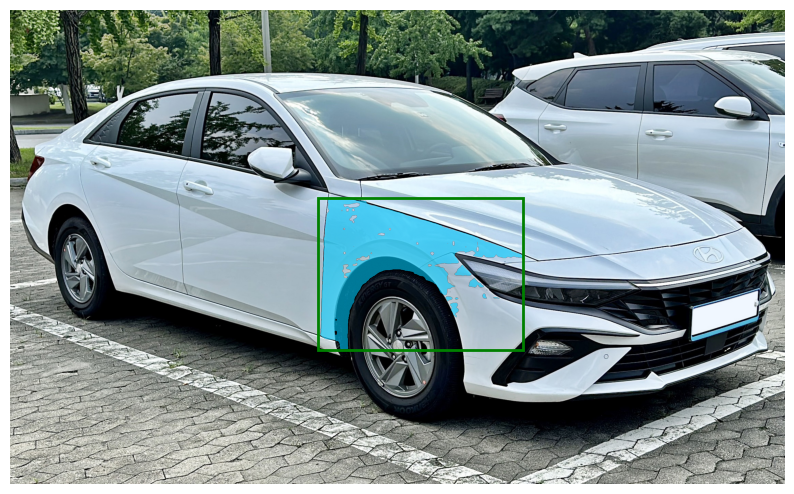

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)


#show_mask(MaskOfBox(bbbox_3)[2], [1, 0.8, 0], plt.gca())
show_mask(mask_intersection1, [0, 0.8, 1], plt.gca())

#show_mask(l[4], colors[4], plt.gca())
print(labels[1])
show_box(bbbox_2, plt.gca())
#show_box(bbbox_3, plt.gca())
plt.axis('off')
plt.show()

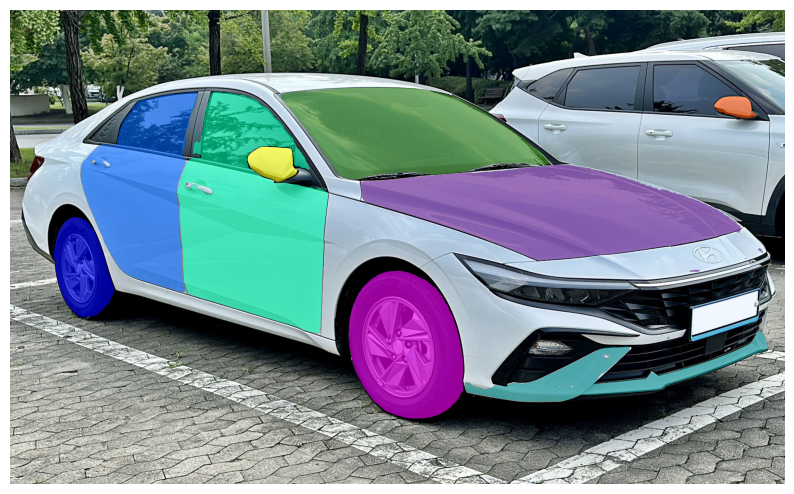

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for (elem, col) in zip(all_masks, colors[:len(all_masks)]):

  show_mask(elem[0], col, plt.gca())
  # break
#show_mask(MaskOfBox(bbbox_3)[2], [1, 0.8, 0], plt.gca())
#show_mask(MaskOfBox(bbbox_2)[2], [0, 0.8, 1], plt.gca())
#show_mask(l[4], colors[4], plt.gca())
#print(labels[1])
#show_box(bbbox_2, plt.gca())
plt.axis('off')
plt.show()

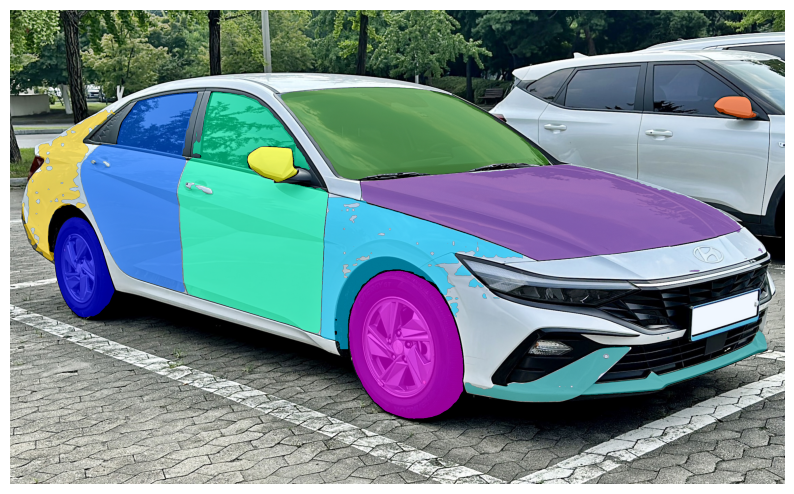

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for (elem, col) in zip(all_masks, colors[:len(all_masks)]):

  show_mask(elem[0], col, plt.gca())
  # break
show_mask(MaskOfBox(bbbox_3)[2], [1, 0.8, 0], plt.gca())
show_mask(mask_intersection1, [0, 0.8, 1], plt.gca())
#show_mask(l[4], colors[4], plt.gca())
#print(labels[1])
#show_box(bbbox_2, plt.gca())
plt.axis('off')
plt.show()

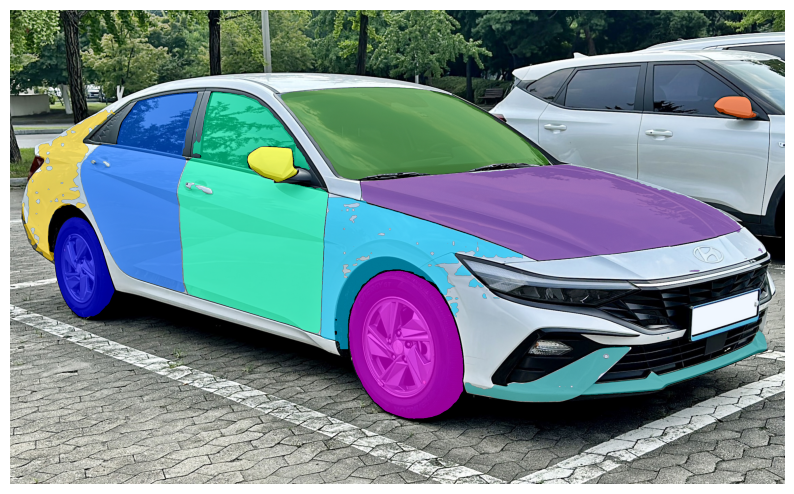

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for (elem, col) in zip(all_masks, colors[:len(all_masks)]):

  show_mask(elem[0], col, plt.gca())
  # break
show_mask(MaskOfBox(bbbox_3)[2], [1, 0.8, 0], plt.gca())
show_mask(mask_intersection1, [0, 0.8, 1], plt.gca())
#show_mask(l[4], colors[4], plt.gca())
#print(labels[1])
#show_box(bbbox_2, plt.gca())
plt.axis('off')
plt.show()

In [ ]:
#binaryMaskIOU(ground_truth_mask, MaskOfBox(np.array(bbox)[4])[0])

In [ ]:
init_model = YOLO('/content/drive/MyDrive/UQTR/SAM-YOLOv8/yolov8_weights/yolov8n.pt')

init_results = init_model.predict(source='/content/drive/MyDrive/UQTR/SAM/hyundai.jpg', conf=0.25)


image 1/1 /content/drive/MyDrive/UQTR/SAM/hyundai.jpg: 416x640 3 cars, 147.4ms
Speed: 20.4ms preprocess, 147.4ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)


In [ ]:
for result in init_results:
    init_boxes = result.boxes
    init_masks = result.masks
    init_labels = result.names
    init_scores = result.probs
car_bboxes = init_boxes.xyxy.tolist()

In [ ]:
#car_bboxes

In [ ]:
car_bboxes_sorted = sort_bbox(car_bboxes)

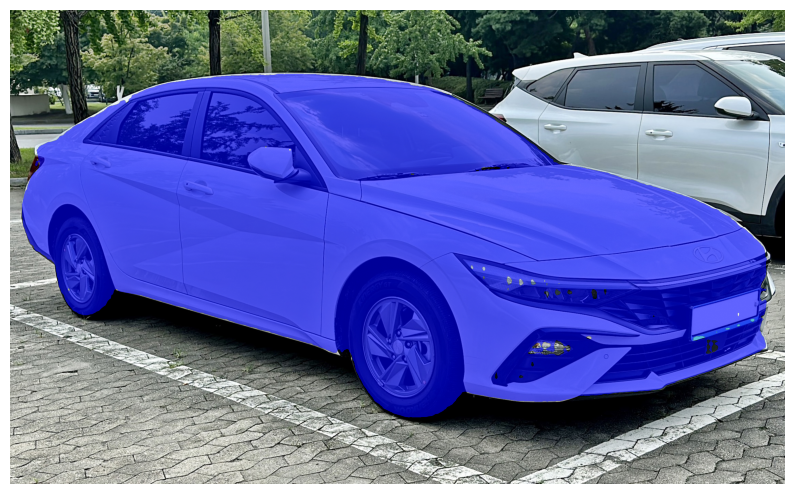

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)

#show_box(np.array(car_bboxes_sorted)[0], plt.gca())
#show_box(np.array(bbox)[7], plt.gca())
#show_box(np.array(car_bboxes_sorted)[2], plt.gca())
show_mask(MaskOfBox(np.array(car_bboxes_sorted)[0])[0], colors[5], plt.gca())

plt.axis('off')
plt.show()

In [ ]:
good_masks = []
bad_masks = []
for box in bbox:
  if binaryMaskIOU(MaskOfBox(box)[0], MaskOfBox(car_bboxes_sorted[0])[0]) != 0:
    good_masks.append(MaskOfBox(box))
  else:
    bad_masks.append(MaskOfBox(box))

In [ ]:
binaryMaskIOU(MaskOfBox(car_bboxes_sorted[0])[0], good_masks[0])

0.2926184312240626

In [ ]:
print(len(good_masks))
print(len(bad_masks))

8
1


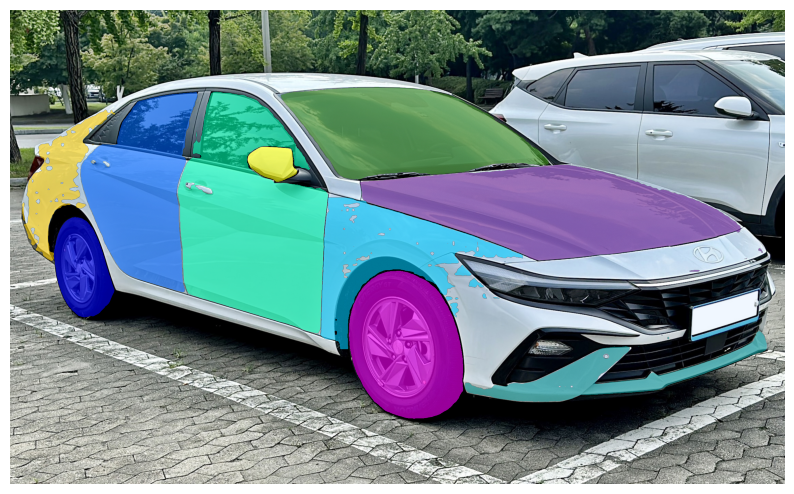

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for (elem, col) in zip(good_masks, colors[:len(good_masks)]):

  show_mask(elem[0], col, plt.gca())
  #break
show_mask(MaskOfBox(bbbox_3)[2], [1, 0.8, 0], plt.gca())
show_mask(mask_intersection1, [0, 0.8, 1], plt.gca())
#show_mask(l[4], colors[4], plt.gca())
#show_box(np.array(bbox)[4], plt.gca())
plt.axis('off')
plt.show()